[![Open In Colab](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&label=%20&labelColor=5c5c5c&color=23c7a2&style=flat-square)](https://colab.research.google.com/github/einbandi/paradime/blob/master/notebooks/mds.ipynb)

# Linear Parametric MDS

In this short example we will learn how to implement a simple parametric version of MDS using the paraDime API. We will also verify that learning a linear transformation with the MDS loss and euclidean distances leads to the same transformation matrix as the one for PCA.

We start by importing some packages and all the relevant paraDime submodules.

In [2]:
import numpy as np
import torch
import sklearn.datasets
import sklearn.decomposition
from matplotlib import pyplot as plt

import paradime.dr
import paradime.relations
import paradime.transforms
import paradime.loss
import paradime.utils

paradime.utils.seed.seed_all(42);

As a toy dataset for this example, we use the diabetes data from sklearn. It consists of 442 datapoints with 10 features that can be used to predict a quantitative measure of disease progression.

In [3]:
diabetes = sklearn.datasets.load_diabetes()
data = diabetes['data']

Let's first perform PCA on the dataset:

In [4]:
pca = sklearn.decomposition.PCA().fit(data)

Before we train an MDS routine, let's first verify that paraDime is working as intended. To do this, we'll check what happens when we attempt to learn a linear transformation that approximates the PCA-transformed data directly using a [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss):

In [5]:
pd_pca = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10,10,bias=False),
    verbose=True,
    losses=paradime.loss.PositionLoss(
        position_key="pca",
        embedding_method="forward",
    )
)

pd_pca.add_training_phase(
    epochs=20,
    batch_size=50,
    report_interval=2,
)

pd_pca.train({
    "main": data,
    "pca": pca.transform(data),
})

2022-12-01 14:59:40,236: Initializing training dataset.
2022-12-01 14:59:40,237: Beginning training phase 'None'.
2022-12-01 14:59:40,274: Loss after epoch 0: 0.01773754076566547
2022-12-01 14:59:40,295: Loss after epoch 2: 0.006515715678688139
2022-12-01 14:59:40,321: Loss after epoch 4: 0.0027095624682260677
2022-12-01 14:59:40,344: Loss after epoch 6: 0.0012391830678097904
2022-12-01 14:59:40,366: Loss after epoch 8: 0.0006386807071976364
2022-12-01 14:59:40,388: Loss after epoch 10: 0.0003415642677282449
2022-12-01 14:59:40,408: Loss after epoch 12: 0.00019737657112273155
2022-12-01 14:59:40,433: Loss after epoch 14: 0.00012344706237854552
2022-12-01 14:59:40,458: Loss after epoch 16: 8.501409502059687e-05
2022-12-01 14:59:40,478: Loss after epoch 18: 6.296478522926918e-05


Let's compare the true PCA tranformation matrix and the one approximated via the [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss):

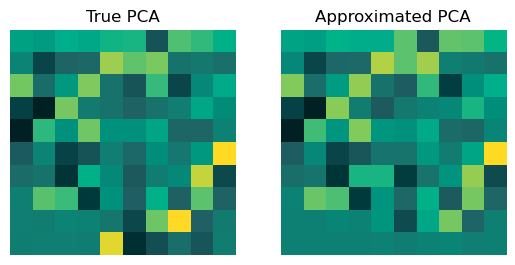

In [6]:
cmap = paradime.utils.plotting.get_colormap()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pca.components_, cmap=cmap)
ax1.set_axis_off()
ax1.set_title("True PCA")
ax2.imshow(pd_pca.model.weight.detach().numpy(), cmap=cmap)
ax2.set_axis_off()
ax2.set_title("Approximated PCA");

As expected, the matrices look very similar. Bigger differences are only visible in the bottom two rows. This makes sense, because these rows correspond to the "least important" components. Getting them wrong affects the overall positions of the tranformed data the least.

Now that we've confirmed that paraDime works correctly in this case, let's move to MDS. The loss used in MDS leads to transformed points that ideally have very similar pairwise distances as the orignal points. We implement this loss with simple pairwise distances as both global and batch-wise relations (the batch ones just have to be differentiable). We compare the two distance matrices in a [RelationLoss](../api/modules.rst#paradime.loss.RelationLoss) using a simple mean square error loss:

In [7]:
def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_mds = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10, 2, bias=False),
    global_relations=paradime.relations.PDist(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_mds.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)

pd_mds.train(data)


2022-12-01 14:59:44,713: Initializing training dataset.
2022-12-01 14:59:44,714: Computing global relations 'rel'.
2022-12-01 14:59:44,715: Calculating pairwise distances.
2022-12-01 14:59:44,719: Beginning training phase 'None'.
2022-12-01 14:59:44,744: Loss after epoch 0: 6230.33740234375
2022-12-01 14:59:45,764: Loss after epoch 50: 1157.6202392578125
2022-12-01 14:59:46,808: Loss after epoch 100: 702.5997314453125
2022-12-01 14:59:47,790: Loss after epoch 150: 655.732177734375
2022-12-01 14:59:48,824: Loss after epoch 200: 643.6032104492188
2022-12-01 14:59:49,889: Loss after epoch 250: 636.4081420898438
2022-12-01 14:59:50,912: Loss after epoch 300: 631.791259765625
2022-12-01 14:59:52,007: Loss after epoch 350: 628.55224609375
2022-12-01 14:59:53,060: Loss after epoch 400: 626.1334228515625
2022-12-01 14:59:54,120: Loss after epoch 450: 624.29833984375


Note that unlike in the PCA case above, where we kept the dimensionality at 10, we here want to learn an embedding into 2 dimensions. Therefore, we'll compare our learned MDS matrix to the top two rows of the PCA matrix, to which it should be similar.

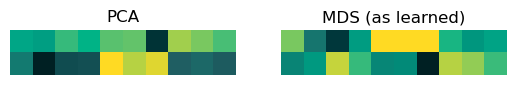

In [8]:
mds_matrix = pd_mds.model.weight.detach().numpy()

cmap = paradime.utils.plotting.get_colormap()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pca.components_[:2], cmap=cmap)
ax1.set_axis_off()
ax1.set_title("PCA")
ax2.imshow(mds_matrix, cmap=cmap)
ax2.set_axis_off()
ax2.set_title("MDS (as learned)");

At first glance this does not look to good. However, remember that MDS only takes into acount pairwise distances. This means that the absolute location of points does not matter; they might mirrored along axes or rotated. If we perform a slight transformation to our MDS matrix, we can verify that it is indeed very similar to PCA. In this case, we just have to reverse the rows, but in other cases it might be necessary to multiply some or all rows by -1.

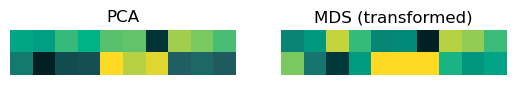

In [9]:
mds_matrix_tf = mds_matrix[::-1]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pca.components_[:2], cmap=cmap)
ax1.set_axis_off()
ax1.set_title("PCA")
ax2.imshow(mds_matrix_tf, cmap=cmap)
ax2.set_axis_off()
ax2.set_title("MDS (transformed)");

Finally, let's compare how the data points look under both tranformations.

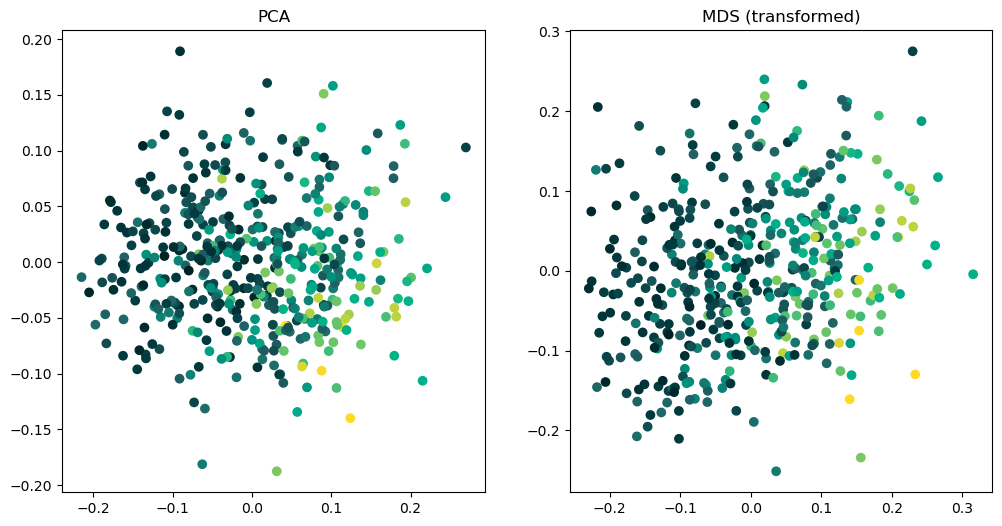

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    *np.stack([np.dot(pca.components_[:2], i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax1.set_title("PCA")
ax2.scatter(
    *np.stack([np.dot(mds_matrix_tf, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax2.set_title("MDS (transformed)");


Also the scatterplots look pretty similar, especially with respect to the spatial distribution of target values (indicated by the color).

We can conclude that the parametric, linear MDS that we defined with paraDime actually did what it was supposed to do.